In [ ]:
# default_exp backwards
# hide
from nbdev.showdoc import *
%load_ext autoreload
%autoreload 2

# `Node2Vec` on MultiTree

In [ ]:
from directed_graphs.datasets import DirectedStochasticBlockModelHelper
from directed_graphs.datasets import visualize_heatmap
import torch

num_nodes = 35
num_clusters = 7

row = [0, 0, 1, 2, 2, 3, 4, 5]
col = [1, 2, 3, 3, 4, 5, 5, 6]
edge_index = torch.tensor([row, col])
data = DirectedStochasticBlockModelHelper(num_nodes=35, num_clusters=7, edge_index=edge_index)[0]

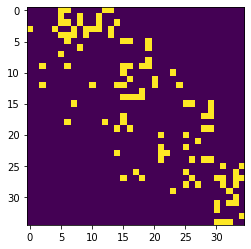

In [ ]:
visualize_heatmap(data.edge_index)

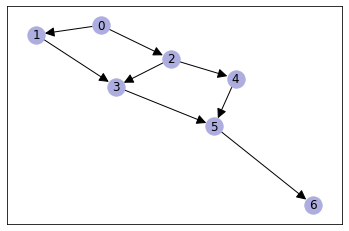

In [ ]:
# export datasets
from torch_geometric.data import Data
from directed_graphs.datasets import visualize_graph
import torch

def visualize_edge_index(num_clusters, edge_index):
  data = Data(x=torch.eye(num_clusters), edge_index=edge_index)
  visualize_graph(data)

visualize_edge_index(num_clusters, edge_index)